<a href="https://colab.research.google.com/github/PocachipMind/Medical-Image-Processing-Model-Development/blob/main/1.2.%20Medical%20image%20acquisition/Monai_torchio_libary/monai_torchio_libary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

### 코랩 환경의 경우 Numpy가 기본 2.xx 이다.
 monai의 경우 numpy<2.0,>=1.24 일때 안정적이므로 버전을 재설정한다. 캐글과 동일하게 버전을 맞춰줍니다. 세션 재시작이 필요합니다.

In [2]:
!pip uninstall -y numpy && pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
import os
print(os.getcwd())

/content


# monai
* 기본적으로 3D data나 medical image에 aug에서는 gray scale이나 hu value의 수정이 필요하기 때문에 전처리등 필요한게 너무 많다.
* 기본적인 전처리인 HU value를 잘라서 전처리를 하거나 픽셀 스페이싱에 맞춰서 이미지를 키우는 방법에 대해서도 많이 제공함.

https://monai.io/index.html

In [2]:
import monai
from monai.apps import DecathlonDataset, download_and_extract
from monai.data import DataLoader, Dataset # 토치 베이스 데이터 셋 제공. 니프티나 달콤 이미지 데이터 불러오기, 어그멘테이션 적용에 용이함.
from monai.transforms import (
    EnsureChannelFirstd, ## tesor로 변경하기 위해 channel로 옮김
    LoadImaged, ## nifiti, dicom image 읽어오기
    Spacingd, ## 이미지의 pixel간의 spacing을 interpolationd을 쉽게 해줌
    Orientationd, ## 이미지의 위치를 다시 정렬  Left (L), Right (R), Posterior (P), Anterior (A), Inferior (I), Superior (S).
    ScaleIntensityRanged, # min, max범위를 and scales to (0, 1) 하는 방법
    Compose,  ## 해당 augmentationd을 list로 묶어서 사용
    OneOf, ## 여러 Augmenation중에 하나를 선택하기
    CropForegroundd, ## Foreground부분만 남기는 방법
    Rand3DElasticd, ## 3D 모양으로 Elastic Transform ( 3D 형태로 외곡 )
    RandAffined, ## 이미지의 크기는고정인 상태로 augmenation 함수
    RandRotated, ## random roatate
    RandFlipd,

)
import tempfile
from monai.visualize.utils import (
    blend_images,## label과 Image를 합친 영상 [ 이미지와 마스크를 블랜드하고 자연스럽게 섞어주는 ]
    matshow3d ## 3d image의 visulization [ 3D 이미지를 2D 이미지로 플랏 ]
)
import matplotlib.pyplot as plt

* Monai의 경우 이미지를 다운로드 받기에 용이하다.
* 새로운 3d image를 다운로드 해보자.

In [3]:
import os

directory = "temp"  # 현재 디렉토리에 "temp" 폴더를 생성하려면 "temp"로 지정
root_dir = os.path.abspath(directory)  # 절대 경로 변환

# 폴더가 없으면 생성
os.makedirs(root_dir, exist_ok=True)

print("Root Directory:", root_dir)

resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar" # 용량이 적어서 선택

compressed_file = os.path.join(root_dir, "Task02_Heart.tar")
data_dir = os.path.join(root_dir, "Task02_Heart")
if not os.path.exists(data_dir):
  download_and_extract(resource, compressed_file, root_dir)

Root Directory: /content/temp


Task02_Heart.tar: 435MB [00:14, 30.9MB/s]                           

2025-03-24 10:22:55,735 - INFO - Downloaded: /content/temp/Task02_Heart.tar
2025-03-24 10:22:55,739 - INFO - Expected md5 is None, skip md5 check for file /content/temp/Task02_Heart.tar.
2025-03-24 10:22:55,740 - INFO - Writing into directory: /content/temp.


data_dir가 존재하지 않는 경우 (Task02_Heart 폴더가 없을 때)만 다운로드 및 압축 해제를 수행합니다.

```download_and_extract(resource, compressed_file, root_dir)```:

```resource```에서 ```compressed_file```을 다운로드합니다.

압축을 ```root_dir```에 풀어줍니다.

In [17]:
ls /content/temp/Task02_Heart/imagesTr

la_003.nii.gz*  la_009.nii.gz*  la_016.nii.gz*  la_020.nii.gz*  la_024.nii.gz*
la_004.nii.gz*  la_010.nii.gz*  la_017.nii.gz*  la_021.nii.gz*  la_026.nii.gz*
la_005.nii.gz*  la_011.nii.gz*  la_018.nii.gz*  la_022.nii.gz*  la_029.nii.gz*
la_007.nii.gz*  la_014.nii.gz*  la_019.nii.gz*  la_023.nii.gz*  la_030.nii.gz*


In [18]:
ls -a /content/temp/Task02_Heart/imagesTr

./              la_005.nii.gz*  la_011.nii.gz*  la_018.nii.gz*  la_022.nii.gz*  ._la_029.nii.gz*
../             la_007.nii.gz*  la_014.nii.gz*  la_019.nii.gz*  la_023.nii.gz*  la_029.nii.gz*
la_003.nii.gz*  la_009.nii.gz*  la_016.nii.gz*  la_020.nii.gz*  la_024.nii.gz*  la_030.nii.gz*
la_004.nii.gz*  la_010.nii.gz*  la_017.nii.gz*  la_021.nii.gz*  la_026.nii.gz*


In [19]:
train_images = list((Path(data_dir)/"imagesTr").glob("*.nii.gz"))
train_labels = list((Path(data_dir)/"labelsTr").glob("*.nii.gz"))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_data_dicts, val_data_dicts = data_dicts[:-9], data_dicts[-9:]
train_data_dicts[0]

{'image': PosixPath('/content/temp/Task02_Heart/imagesTr/la_026.nii.gz'),
 'label': PosixPath('/content/temp/Task02_Heart/labelsTr/la_026.nii.gz')}

In [20]:
train_labels # 다음과 같이 숨김 폴더도 같이 들어가서 버그가 걸림!

[PosixPath('/content/temp/Task02_Heart/labelsTr/la_026.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_014.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_023.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_016.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_011.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_017.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_019.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_004.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/._la_029.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_007.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_020.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_003.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/._la_014.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_018.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_021.nii.gz'),
 PosixPath('/content/

In [21]:
train_labels = sorted(
    [f for f in (Path(data_dir) / "labelsTr").glob("*.nii.gz") if not f.name.startswith("._")]
)

In [22]:
train_labels

[PosixPath('/content/temp/Task02_Heart/labelsTr/la_003.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_004.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_005.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_007.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_009.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_010.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_011.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_014.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_016.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_017.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_018.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_019.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_020.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_021.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/labelsTr/la_022.nii.gz'),
 PosixPath('/content/temp

In [23]:
train_images = sorted(
    [f for f in (Path(data_dir) / "imagesTr").glob("*.nii.gz") if not f.name.startswith("._")]
)

In [24]:
train_images

[PosixPath('/content/temp/Task02_Heart/imagesTr/la_003.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/imagesTr/la_004.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/imagesTr/la_005.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/imagesTr/la_007.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/imagesTr/la_009.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/imagesTr/la_010.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/imagesTr/la_011.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/imagesTr/la_014.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/imagesTr/la_016.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/imagesTr/la_017.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/imagesTr/la_018.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/imagesTr/la_019.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/imagesTr/la_020.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/imagesTr/la_021.nii.gz'),
 PosixPath('/content/temp/Task02_Heart/imagesTr/la_022.nii.gz'),
 PosixPath('/content/temp

In [25]:
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_data_dicts, val_data_dicts = data_dicts[:-9], data_dicts[-9:]
train_data_dicts[0]

{'image': PosixPath('/content/temp/Task02_Heart/imagesTr/la_003.nii.gz'),
 'label': PosixPath('/content/temp/Task02_Heart/labelsTr/la_003.nii.gz')}

이미지 읽기

image shape: torch.Size([1, 320, 320, 100])
label shape: torch.Size([1, 320, 320, 100])
pixel spacing: tensor([1.2500, 1.2500, 1.3700], dtype=torch.float64)


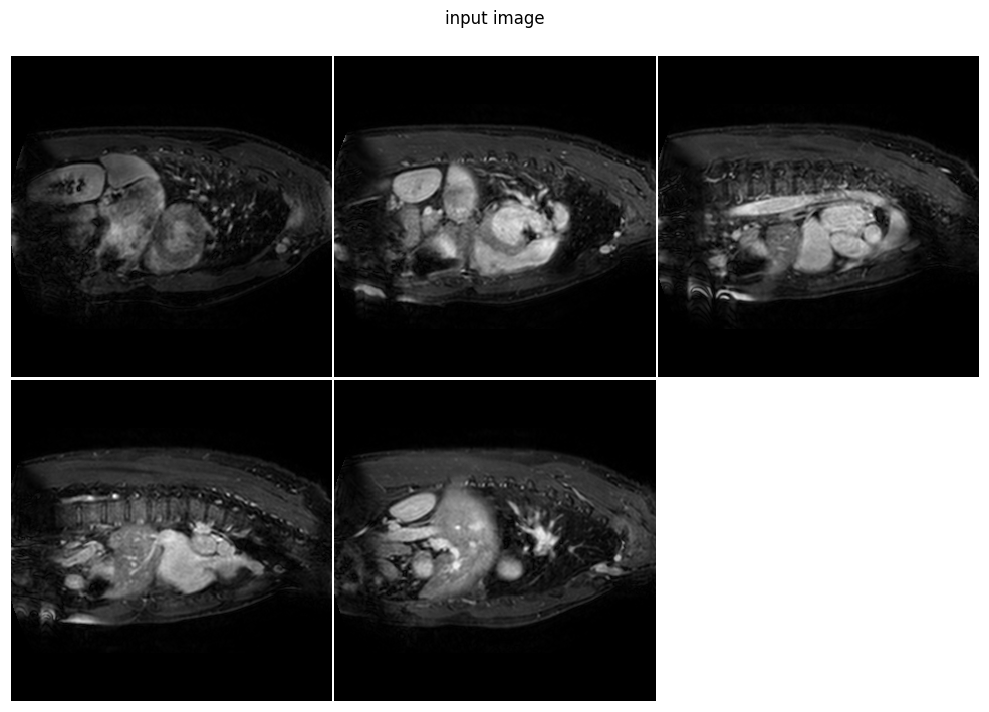

In [26]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
    ])
dataset = Dataset(data=val_data_dicts, transform=transform)

print(f"image shape: {dataset[0]['image'].shape}")
print(f"label shape: {dataset[0]['label'].shape}")
print(f"pixel spacing: {dataset[0]['image'].pixdim}")
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)

In [32]:
# 픽셀 스페이싱 늘려보기!
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(2, 2, 3), mode=("bilinear", "nearest"))
    ])
dataset = Dataset(data=val_data_dicts, transform=transform)

```Spacingd(keys=["image", "label"], pixdim=(2, 2, 3), mode=("bilinear", "nearest")```

각 인자의 의미
1. keys=["image", "label"]

  image와 label 데이터를 변환 대상으로 지정.

  image는 MRI/CT 같은 의료 영상 데이터를 의미.

  label은 segmentation이나 classification을 위한 라벨(mask) 데이터를 의미.

2. pixdim=(2, 2, 3)

  원하는 출력 해상도의 픽셀 간격(voxel spacing, 해상도 단위) 을 지정.

  (X, Y, Z) 방향으로 각각 2mm, 2mm, 3mm 간격을 갖도록 변환함.

  예를 들어, 원래 해상도가 (1, 1, 1) (1mm x 1mm x 1mm)였다면, 이를 (2mm x 2mm x 3mm)로 리샘플링하여 해상도를 줄이는 것.

3. mode=("bilinear", "nearest")

  리샘플링할 때 사용할 보간(interpolation) 방법을 지정.

  "bilinear": image에 대해 선형 보간(bilinear interpolation) 사용 → 부드럽게 변환됨.

  "nearest": label에 대해 최근접 이웃 보간(nearest neighbor interpolation) 사용 → 카테고리형 데이터(라벨)가 손상되지 않음.

image의 scale을 spacing에 따라 resampling을 함으로써 작은 object에 크게 학습을 할수 있게 되어진다.

image shape: torch.Size([1, 224, 320, 100])
label shape: torch.Size([1, 224, 320, 100])
pixel spacing: tensor([1.2500, 1.2500, 1.3700], dtype=torch.float64)


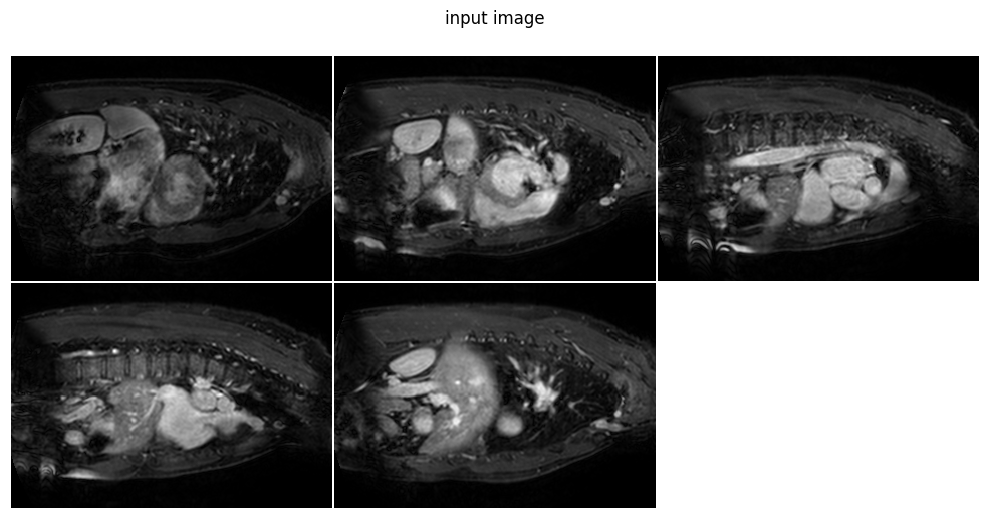

In [35]:
# 스페이싱 조정으로 이미지 사이즈가 줄어듬
print(f"image shape: {dataset[0]['image'].shape}")
print(f"label shape: {dataset[0]['label'].shape}")
print(f"pixel spacing: {dataset[0]['image'].pixdim}")
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)

Foreground영역의 분할을 할경우 background의 noised영역이 제거 됨으로 cost가 줄어든다.

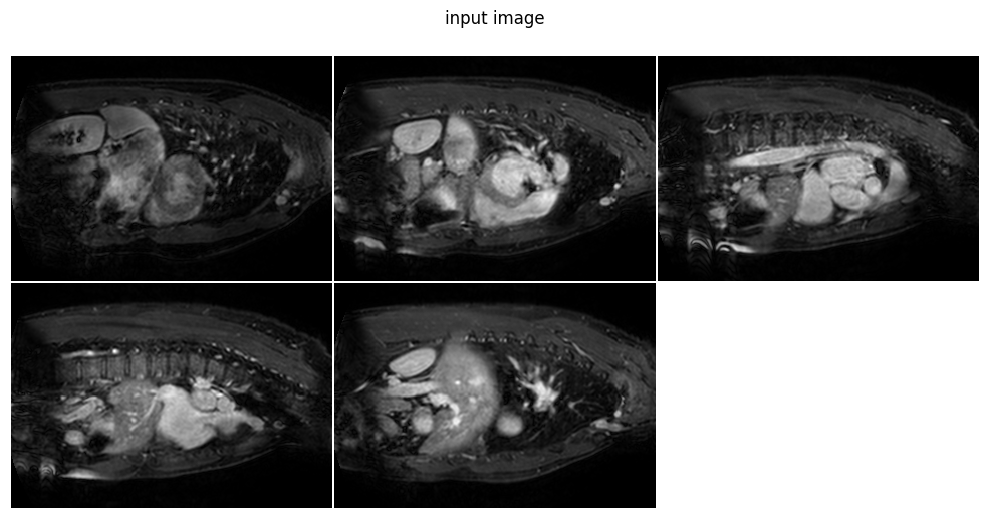

In [36]:
# Foreground 없어짐
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
#         NormalizeIntensityd(keys=["image"])
    ])

dataset = Dataset(data=val_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)


In [37]:
dataset[0]['image'].max()

metatensor(1662.)

In [38]:
from monai.transforms import NormalizeIntensityd # 노멀라이즈, 즉 정규화

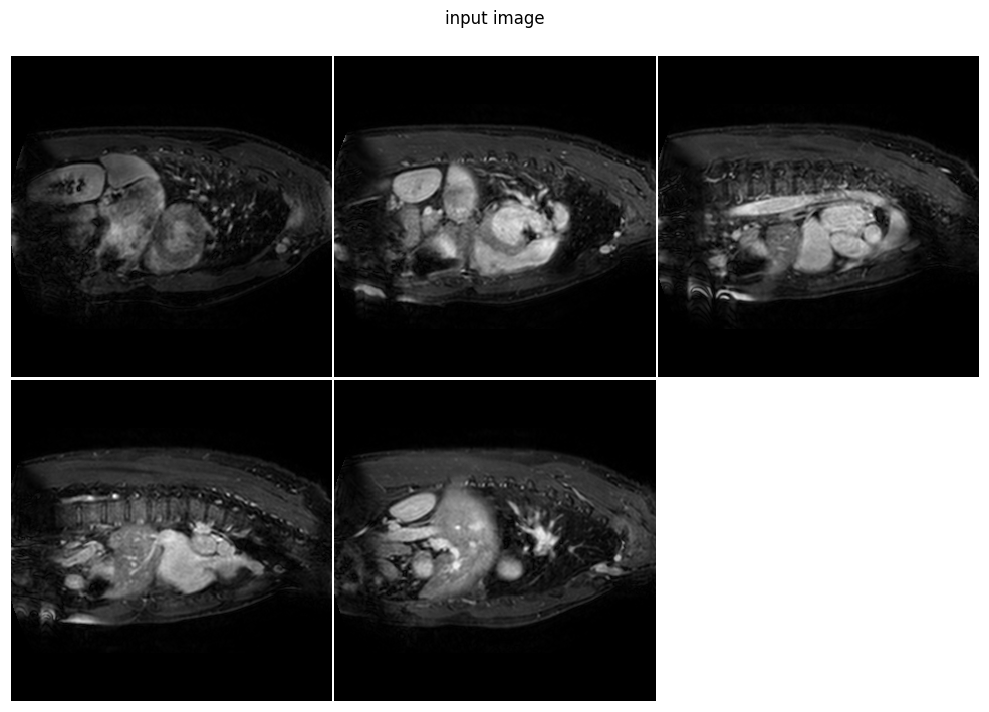

In [39]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        NormalizeIntensityd(keys="image", channel_wise=True),
    ])

dataset = Dataset(data=val_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)


In [41]:
dataset[0]['image'].max() # 최고값이 줄어들었음.

metatensor(6.1753)

In [42]:
from monai.transforms import (
    EnsureChannelFirstd, ## tesor로 변경하기 위해 channel로 옮김
    LoadImaged, ## nifiti, dicom image 읽어오기
    Spacingd, ## 이미지의 pixel간의 spacing을 interpolationd을 쉽게 해줌
    Orientationd, ## 이미지의 위치를 다시 정렬  Left (L), Right (R), Posterior (P), Anterior (A), Inferior (I), Superior (S).
    ScaleIntensityRanged, # min, max범위를 and scales to (0, 1) 하는 방법
    Compose,  ## 해당 augmentationd을 list로 묶어서 사용
    OneOf, ## 여러 Augmenation중에 하나를 선택하기
    CropForegroundd, ## Foreground부분만 남기는 방법
    Rand3DElasticd, ## 3D 모양으로 Elastic Transform
    RandAffined, ## 이미지의 크기는고정인 상태로 augmenation 함수
    RandRotated, ## random roatate
    RandFlip,
    RandRotate90d,
)


In [43]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=1,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=1,
            max_k=3,
        )

    ])

dataset = Dataset(data=val_data_dicts, transform=transform)


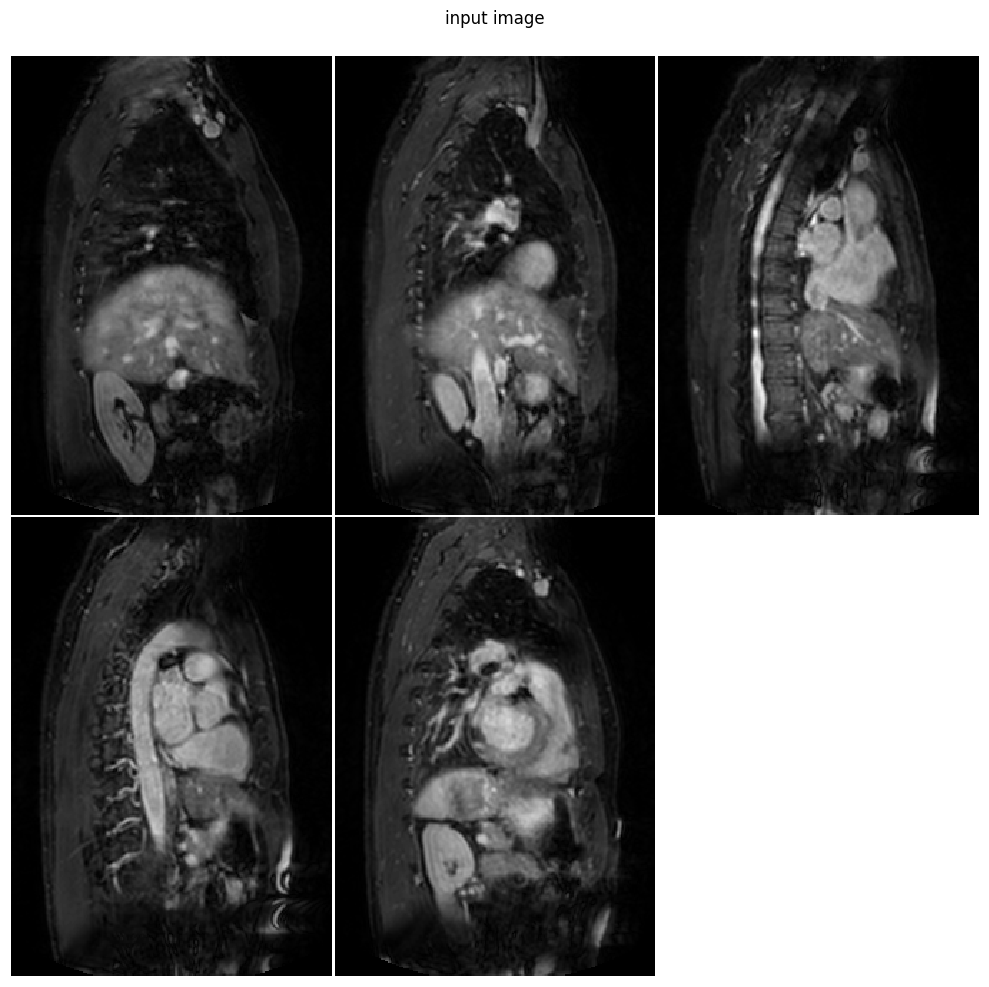

In [44]:
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)


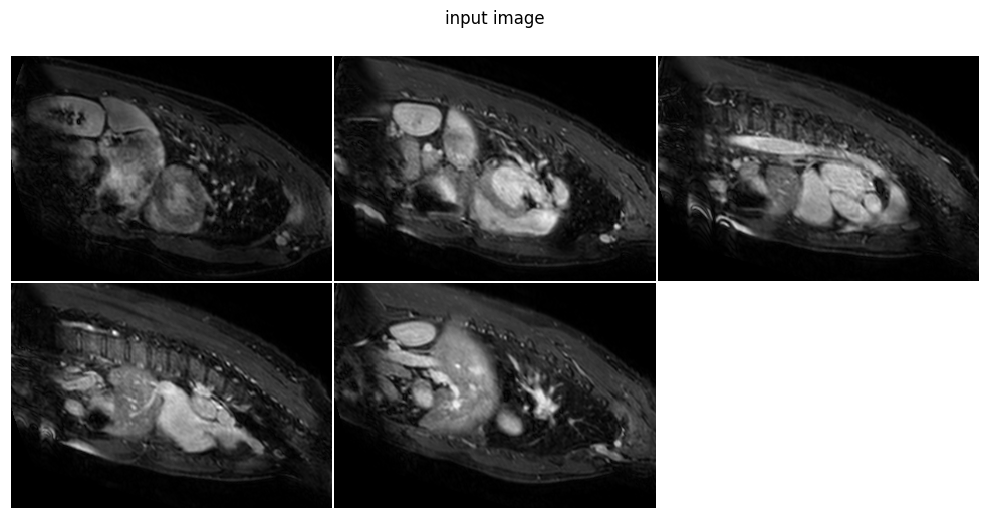

In [45]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandAffined(
            keys=["image", "label"],
            shear_range=(0.5,0.5), mode='bilinear', padding_mode='zeros',
            prob=1,
        ),
    ])

dataset = Dataset(data=val_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)


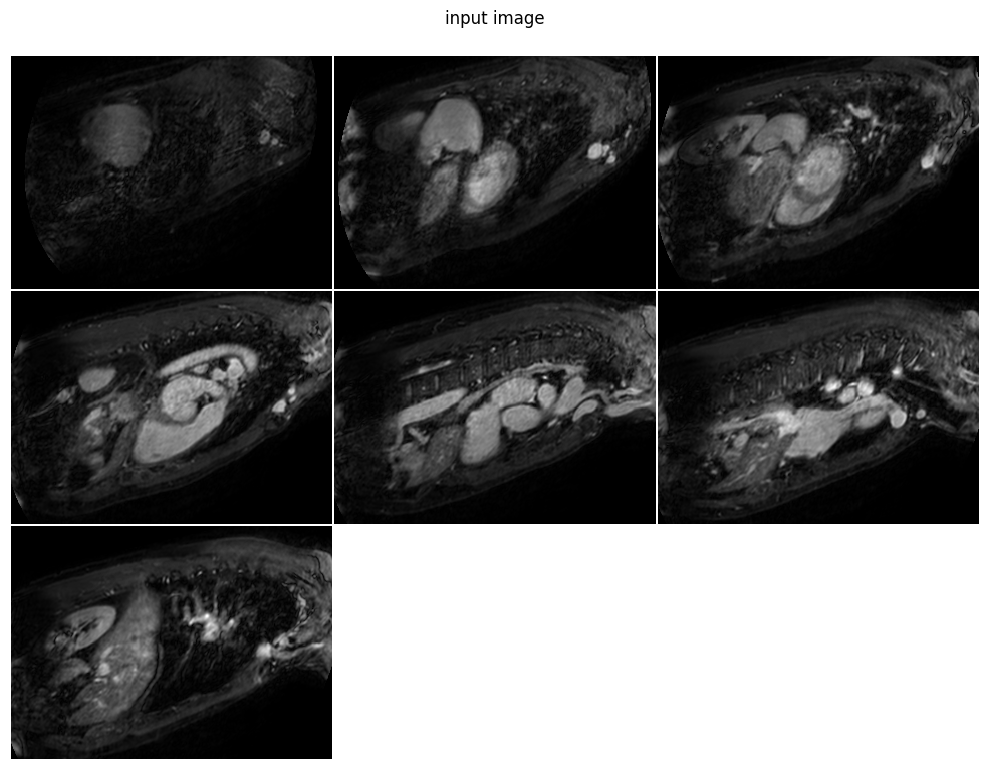

In [46]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandAffined(
            keys=["image", "label"],
            shear_range=(0.5,0.5), mode='bilinear', padding_mode='zeros',
            prob=1,
        ),
    ])

dataset = Dataset(data=train_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)


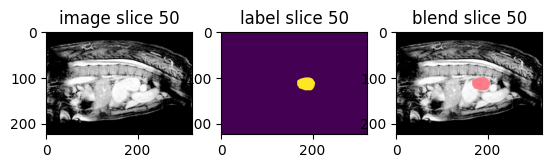

In [51]:
# 이미지에 마스크 있도록 보고싶을 때, 어떻게 어그멘테이션이 잘되었는지 확인하고자 할 때 blend_images 통해서

import torch
import matplotlib.pyplot as plt

ret = blend_images(image=dataset[0]["image"], label=dataset[0]["label"], alpha=0.5, cmap="hsv", rescale_arrays=True)
fig,axs = plt.subplots(1,3)
# plot the slice 50 - 100 of image, label and blend result
slice_index = 10 * 5
axs[0].set_title(f"image slice {slice_index}")
axs[0].imshow(dataset[0]["image"][0, :, :, slice_index], cmap="gray")
axs[1].set_title(f"label slice {slice_index}")
axs[1].imshow(dataset[0]["label"][0, :, :, slice_index])
axs[2].set_title(f"blend slice {slice_index}")
axs[2].imshow(torch.moveaxis(ret[:, :, :, slice_index], 0, -1))

In [48]:
### hard augmenation
from monai.transforms import (
    RandKSpaceSpikeNoised, ## 주파수 영역의 이미지에서 noise를 추가하여준다 .
    AdjustContrastd, ## 영상의 밝기 조절
    GaussianSmoothd, ## 이미지에 Gaussian을 적용하여 smooth하게 만듬
    RandCoarseDropoutd, ## Cutout처럼 이미지에 특정영역에 box를 적용
    HistogramNormalized, ## 이미지의 histogram을 normalize함으로써 영상의 밝기 향상
)


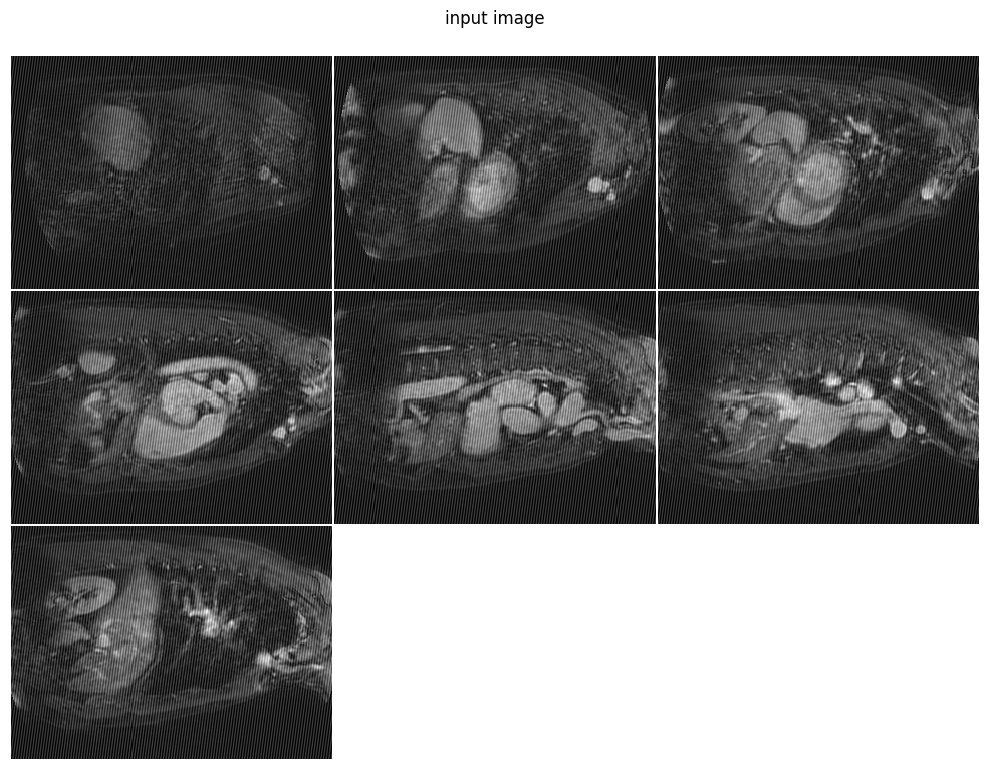

In [49]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=1800,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandKSpaceSpikeNoised(keys=["image"], prob=1, intensity_range=(13, 15), channel_wise=True), # 노이즈
    ])

dataset = Dataset(data=train_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)




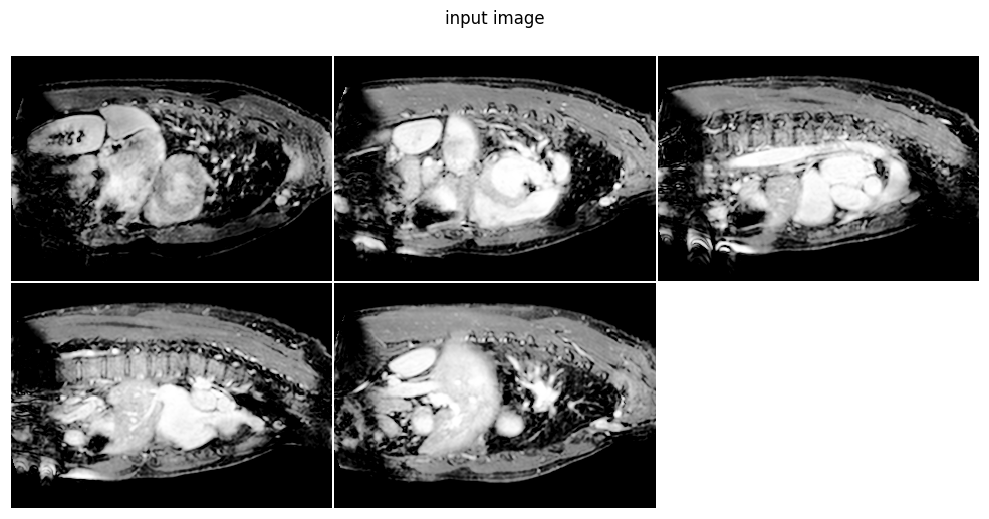

In [50]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=1800,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        HistogramNormalized(keys=["image"], num_bins=10),   # 밝아짐
    ])

dataset = Dataset(data=val_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)




Torchio라는 어그가있습니다.

조금 더 시각화하기 편합니다.

In [52]:
!pip install torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.8/175.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 14.2 MB/s eta 0:00:00


In [53]:
import torchio as tio

# transform = tio.RandomAffine(scales=(1.2, 1.2), degrees=30, translation=10)

In [54]:
colin = tio.datasets.Colin27()
transforms_dict = {
    tio.RandomAffine(): 0.75,
    tio.RandomElasticDeformation(): 0.25,
}  # Using 3 and 1 as probabilities would have the same effect
transform = tio.OneOf(transforms_dict)

transformed = transform(colin)

24256512it [00:02, 9606028.38it/s]                               


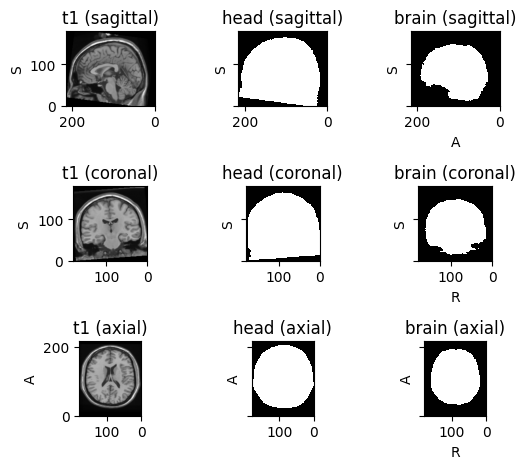

In [55]:
transformed.plot()

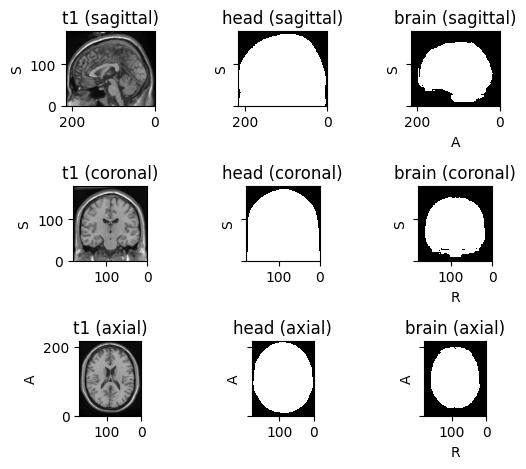

In [56]:
colin.plot()

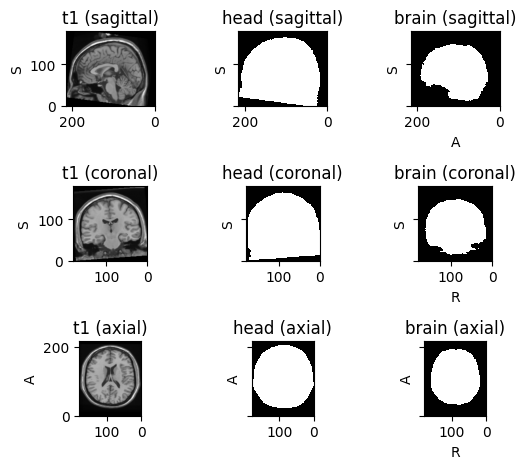

In [57]:
transformed.plot()

In [ ]:
###